In [1]:
from core.networks.SRGAN import FeatureExtractor, Generator, Discriminator

import json

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import models
from torchsummary import summary
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
from safetensors.torch import load_model, save_model
from ignite.engine import Engine, Events
from ignite.metrics import SSIM, PSNR, RunningAverage
from ignite.handlers import LRScheduler
from ignite.contrib.handlers import (
    TensorboardLogger,
    global_step_from_engine,
    ProgressBar,
)

from data.get_data import (
    get_bsd100,
    get_bsds500,
    get_div2k_huggingface,
    get_div2k_custom,
)
import core.utils as U
from core.device import get_device
from core.loss import GeneratorLoss
from core.scheduler import CosineAnnealingWarmupRestarts

In [2]:
from IPython.core.display import HTML

HTML(
    r"""
<style>
    * {
        #color: red;
        #font-family: ‘Cascadia Code PL’;#,‘Courier New’, Courier, monospace; 
        font-family: 'Jetbrains Mono', Courier, monospace; 
        font-size: 14px !important;
        line-height: 1.3 !important;
    }
    .output-plaintext, .output-stream, .output {
        font-family: 'Jetbrains Mono', Courier, monospace; # Any monospaced font should work
        line-height: 1.5 !important;
        font-size: 14px !important;
    }
</style>
"""
)

In [3]:
model_path = "./models"
result_path = "./results/SRGAN"

batch_size = 12
epochs = 50
generator_lr = 0.001
discriminator_lr = 0.001
scheduler_milestone = [10, 20, 30, 40]
scheduler_gamma = 0.5
generator_weight_decay = 0.0001
discriminator_weight_decay = 0.0001
betas = (0.9, 0.999)
generator_blocks = 4
upscale_factor = 4
real_label = 0.95
fake_label = 0.0
pre_training = True
pre_training_epochs = 5

log_interval_epoch = 5

generator_name = "SRGAN_generator"
discriminator_name = "SRGAN_discriminator"
device = get_device()

print("Hyper Parameters")
print(f"batch_size: {batch_size}")
print(f"pre_training: {pre_training}")
print(f"epochs: {epochs}")
print(f"generator_lr: {generator_lr}")
print(f"discriminator_lr: {discriminator_lr}")
print(f"scheduler_milestone: {scheduler_milestone}")
print(f"scheduler_gamma: {scheduler_gamma}")
print(f"generator_blocks: {generator_blocks}")
print(f"upscale_factor: {upscale_factor}")
if pre_training:
    print(f"pre_training_epochs: {pre_training_epochs}")

Hyper Parameters
batch_size: 12
pre_training: True
epochs: 50
generator_lr: 0.001
discriminator_lr: 0.001
scheduler_milestone: [10, 20, 30, 40]
scheduler_gamma: 0.5
generator_blocks: 4
upscale_factor: 4
pre_training_epochs: 5


In [4]:
# train_loader, val_loader, test_loader = get_bsds500(upscale_factor, batch_size)
# train_loader, val_loader = get_div2k_huggingface(upsacle_factor, batch_size)
train_loader, val_loader = get_div2k_custom(batch_size)
test_loader = get_bsd100(4, 10)
print(f"train iterations per epoch: {len(train_loader)}")
print(f"val iterations per epoch: {len(val_loader)}")

Found cached dataset div2k (C:/Users/thinl/.cache/huggingface/datasets/eugenesiow___div2k/bicubic_x4/2.0.0/d7599f94c7e662a3eed3547efc7efa52b2ed71082b40fc2e42a693870e35b677)


train iterations per epoch: 267
val iterations per epoch: 9


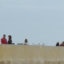

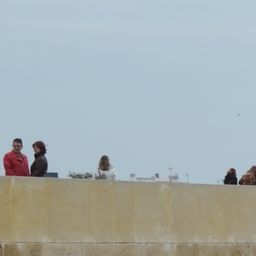

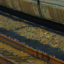

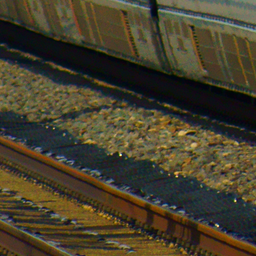

In [5]:
data_iter = iter(train_loader)
z, targets = next(data_iter)

for i in range(min(2, len(z))):
    input_image = TF.to_pil_image(z[i])
    target_image = TF.to_pil_image(targets[i])
    display(input_image)
    display(target_image)

In [6]:
generator = Generator(generator_blocks)
discriminator = Discriminator()

use_pretrained_model = False

try:
    load_model(generator, f"{model_path}/{generator_name}.safetensors")
    load_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")
    use_pretrained_model = True
    print("Using pretrained models")
except:
    print("No pretrained models found")

generator.to(device)
discriminator.to(device)

print("Model loaded")

No pretrained models found
Model loaded


In [7]:
print("Generator Summary")
summary(generator, input_size=(3, 64, 64), batch_size=batch_size, device=device.type)

Generator Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [12, 64, 64, 64]          15,552
             PReLU-2           [12, 64, 64, 64]               1
            Conv2d-3           [12, 64, 64, 64]          36,864
       BatchNorm2d-4           [12, 64, 64, 64]             128
             PReLU-5           [12, 64, 64, 64]               1
            Conv2d-6           [12, 64, 64, 64]          36,864
       BatchNorm2d-7           [12, 64, 64, 64]             128
         GResBlock-8           [12, 64, 64, 64]               0
            Conv2d-9           [12, 64, 64, 64]          36,864
      BatchNorm2d-10           [12, 64, 64, 64]             128
            PReLU-11           [12, 64, 64, 64]               1
           Conv2d-12           [12, 64, 64, 64]          36,864
      BatchNorm2d-13           [12, 64, 64, 64]             128
        GResBlock-14 

In [8]:
print("Discriminator Summary")
summary(
    discriminator, input_size=(3, 256, 256), batch_size=batch_size, device=device.type
)

Discriminator Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [12, 64, 256, 256]           1,728
         LeakyReLU-2         [12, 64, 256, 256]               0
            Conv2d-3         [12, 64, 128, 128]          36,864
       BatchNorm2d-4         [12, 64, 128, 128]             128
         LeakyReLU-5         [12, 64, 128, 128]               0
        DConvBlock-6         [12, 64, 128, 128]               0
            Conv2d-7        [12, 128, 128, 128]          73,728
       BatchNorm2d-8        [12, 128, 128, 128]             256
         LeakyReLU-9        [12, 128, 128, 128]               0
       DConvBlock-10        [12, 128, 128, 128]               0
           Conv2d-11          [12, 128, 64, 64]         147,456
      BatchNorm2d-12          [12, 128, 64, 64]             256
        LeakyReLU-13          [12, 128, 64, 64]               0
       DConvBlock

In [9]:
discriminator_optimizer = optim.AdamW(
    discriminator.parameters(),
    lr=discriminator_lr,
    betas=betas,
    weight_decay=discriminator_weight_decay,
)
generator_optimizer = optim.AdamW(
    generator.parameters(),
    lr=generator_lr,
    betas=betas,
    weight_decay=generator_weight_decay,
)
pre_training_optimizer = optim.AdamW(
    generator.parameters(),
    lr=generator_lr,
    betas=betas,
    weight_decay=generator_weight_decay,
)

discriminator_scheduler = lr_scheduler.MultiStepLR(
    discriminator_optimizer, scheduler_milestone, gamma=scheduler_gamma
)

generator_scheduler = lr_scheduler.MultiStepLR(
    generator_optimizer, scheduler_milestone, gamma=scheduler_gamma
)

discriminator_criterion = nn.BCELoss().to(device)
generator_criterion = GeneratorLoss().to(device)
pre_training_criterion = nn.L1Loss().to(device)

vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg.eval()
feature_extractor = FeatureExtractor(vgg).to(device)

pixel_criterion = nn.L1Loss().to(device)
content_criterion = nn.L1Loss().to(device)
adversarial_criterion = nn.BCELoss().to(device)

pre_training_loss_history = []

loss_history = {
    "g_loss": [],
    "d_loss": [],
    "g_score": [],
    "d_score": [],
    "psnr": [],
    "ssim": [],
}

metrics = {
    "ssim": SSIM(1.0, device=device),
    "psnr": PSNR(1.0, device=device),
}

In [10]:
if pre_training:

    def generator_pre_training_step(engine, data):
        generator.train()

        z, targets = data[0].to(device), data[1].to(device)

        generator.zero_grad()

        G_z = generator(z)

        g_loss = pre_training_criterion(G_z, targets)

        g_loss.backward()

        pre_training_optimizer.step()

        return g_loss.cpu().item()

    pre_training_trainer = Engine(generator_pre_training_step)

    @pre_training_trainer.on(Events.EPOCH_COMPLETED)
    def store_losses(engine):
        out = engine.state.output
        pre_training_loss_history.append(out)

    @pre_training_trainer.on(Events.EPOCH_COMPLETED)
    def log_result(engine):
        print(f"Epoch {engine.state.epoch}/{pre_training_epochs} completed")
        print(f"Generator pre-training loss: {pre_training_loss_history[-1]:.4f}")

    @pre_training_trainer.on(Events.EPOCH_COMPLETED)
    def save_images(engine):
        generator.eval()
        with torch.no_grad():
            data_iter = iter(train_loader)
            z, targets = next(data_iter)
            target_image = TF.to_pil_image(targets[0])

            generated = generator(z[0].unsqueeze(0).to(device))
            generated_image = TF.to_pil_image(generated.cpu().squeeze(0))

            target_image.save(
                f"{result_path}/img/pre-training/{engine.state.epoch}_target.png"
            )
            generated_image.save(
                f"{result_path}/img/pre-training/{engine.state.epoch}_generated.png"
            )

    @pre_training_trainer.on(Events.COMPLETED)
    def save():
        with open(f"{result_path}/pre_training_loss.txt", "w", encoding="utf-8") as f:
            f.write(json.dumps(pre_training_loss_history, indent=2))

    pre_training_trainer.run(train_loader, max_epochs=pre_training_epochs)

Epoch 1/5 completed
Generator pre-training loss: 0.0767
Epoch 2/5 completed
Generator pre-training loss: 0.0649
Epoch 3/5 completed
Generator pre-training loss: 0.0453
Epoch 4/5 completed
Generator pre-training loss: 0.0421
Epoch 5/5 completed
Generator pre-training loss: 0.0381


In [11]:
def training_step(engine, data):
    discriminator.train()
    generator.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################

    discriminator.zero_grad()

    z, targets = data[0].to(device), data[1].to(device)
    z_label = torch.full((z.shape[0],), fake_label, device=device)
    targets_label = torch.full((targets.shape[0],), real_label, device=device)

    G_z1 = generator(z)

    D_x = discriminator(targets).view(-1)
    D_G_z1 = discriminator(G_z1).view(-1)

    # ESRGAN
    # D_x_loss = discriminator_criterion(D_x - torch.mean(D_G_z1), targets_label) * 0.5
    # D_G_z1_loss = discriminator_criterion(D_G_z1 - torch.mean(D_x), z_label) * 0.5

    D_x_loss = discriminator_criterion(D_x, targets_label)
    D_G_z1_loss = discriminator_criterion(D_G_z1, z_label)

    D_x_loss.backward()
    D_G_z1_loss.backward(retain_graph=True)

    d_loss = D_x_loss + D_G_z1_loss
    # d_loss.backward(retain_graph=True)

    discriminator_optimizer.step()

    ############################
    # (2) Update G network: minimize 1 - D(G(z)) + Perception Loss + Image Loss + Pixel Loss
    ###########################

    generator.zero_grad()

    D_G_z1 = discriminator(G_z1).view(-1)
    D_x = discriminator(targets).view(-1)

    # ESRGAN
    # D_x_loss = discriminator_criterion(D_x - torch.mean(D_G_z1), z_label)
    # D_G_z1_loss = discriminator_criterion(D_G_z1 - torch.mean(D_x), targets_label)
    # adversarial_loss = (D_x_loss + D_G_z1_loss) * 0.5

    pixel_loss = pixel_criterion(G_z1, targets)
    content_loss = content_criterion(
        feature_extractor(G_z1), feature_extractor(targets)
    )
    adversarial_loss = adversarial_criterion(D_G_z1, targets_label)
    pixel_loss = torch.sum(torch.mul(0.01, pixel_loss))
    content_loss = torch.sum(torch.mul(0.006, content_loss))
    adversarial_loss = torch.sum(torch.mul(1e-3, adversarial_loss))

    g_loss = pixel_loss + content_loss + adversarial_loss

    g_loss.backward()

    G_z2 = generator(z)
    D_G_z2 = discriminator(G_z2)

    generator_optimizer.step()

    discriminator_scheduler.step()
    generator_scheduler.step()

    return {
        "g_loss": g_loss.cpu().item(),
        "d_loss": d_loss.cpu().item(),
        "D_x": D_x.mean().cpu().item(),
        "D_G_z1": D_G_z1.mean().cpu().item(),
        "D_G_z2": D_G_z2.mean().cpu().item(),
    }


def validation_step(engine, data):
    generator.eval()

    with torch.no_grad():
        z, targets = data[0].to(device), data[1].to(device)

        G_z = generator(z)

        return G_z, targets


trainer = Engine(training_step)
val_evaluator = Engine(validation_step)

for name, metric in metrics.items():
    metric.attach(val_evaluator, name)


@trainer.on(Events.ITERATION_COMPLETED)
def save_results(engine):
    out = engine.state.output
    loss_history["g_loss"].append(out["g_loss"])
    loss_history["d_loss"].append(out["d_loss"])
    loss_history["g_score"].append(out["D_G_z2"])
    loss_history["d_score"].append(out["D_x"])


@trainer.on(Events.EPOCH_COMPLETED)
def save_val_results(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss_history["ssim"].append(metrics["ssim"])
    loss_history["psnr"].append(metrics["psnr"])


@trainer.on(Events.EPOCH_COMPLETED(every=log_interval_epoch))
def log_result(engine):
    print(f"========== Epoch {engine.state.epoch}/{epochs} completed ==========")
    print(
        f"g_loss: {loss_history['g_loss'][-1]:.4f}, d_loss: {loss_history['d_loss'][-1]:.4f}, g_score: {loss_history['g_score'][-1]:.4f}, d_score: {loss_history['d_score'][-1]:.4f}"
    )

    metrics = val_evaluator.state.metrics
    print(f"Validation evalutate - ssim: {metrics['ssim']}, psnr: {metrics['psnr']}")


@trainer.on(Events.EPOCH_COMPLETED)
def save_images(engine):
    generator.eval()
    with torch.no_grad():
        dateiter = iter(train_loader)
        z, targets = next(dateiter)
        target_image = TF.to_pil_image(targets[0])

        generated = generator(z[0].unsqueeze(0).to(device))
        generated_image = TF.to_pil_image(generated.cpu().squeeze(0))

        target_image.save(f"{result_path}/img/{engine.state.epoch}_target.png")
        generated_image.save(f"{result_path}/img/{engine.state.epoch}_generated.png")


@trainer.on(Events.COMPLETED)
def save():
    with open(f"{result_path}/SRGAN.txt", "w", encoding="utf-8") as f:
        f.write(json.dumps(loss_history, indent=2))

    save_model(generator, f"{model_path}/{generator_name}.safetensors")
    save_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")


RunningAverage(output_transform=lambda x: x["g_loss"]).attach(trainer, "g_loss")
RunningAverage(output_transform=lambda x: x["d_loss"]).attach(trainer, "d_loss")
RunningAverage(output_transform=lambda x: x["D_x"]).attach(trainer, "D_x")
RunningAverage(output_transform=lambda x: x["D_G_z2"]).attach(trainer, "D_G_z2")

ProgressBar().attach(trainer, metric_names=["g_loss", "d_loss", "D_x", "D_G_z2"])
ProgressBar().attach(val_evaluator)

In [12]:
tb_logger = TensorboardLogger(log_dir=result_path)

for tag, evaluator in [("validation", val_evaluator)]:
    tb_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag=tag,
        metric_names="all",
        global_step_transform=global_step_from_engine(trainer),
    )

In [13]:
trainer.run(train_loader, max_epochs=epochs)

tb_logger.close()

[1/9]  11%|#1         [00:00<?]

========== Epoch 5/50 completed ==========
g_loss: 0.0015, d_loss: 1.4073, g_score: 0.4892, d_score: 0.4889
Validation evalutate - ssim: 0.6697340613223642, psnr: 24.953834223401433


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 10/50 completed ==========
g_loss: 0.0017, d_loss: 1.3947, g_score: 0.4692, d_score: 0.4698
Validation evalutate - ssim: 0.6780070913064903, psnr: 25.161086003137022


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 15/50 completed ==========
g_loss: 0.0016, d_loss: 1.4173, g_score: 0.4812, d_score: 0.4769
Validation evalutate - ssim: 0.6827619716713427, psnr: 25.29973216683132


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 20/50 completed ==========
g_loss: 0.0016, d_loss: 1.3819, g_score: 0.4767, d_score: 0.4731
Validation evalutate - ssim: 0.6875148988047076, psnr: 25.415707790733155


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 25/50 completed ==========
g_loss: 0.0020, d_loss: 1.2679, g_score: 0.4456, d_score: 0.5470
Validation evalutate - ssim: 0.6598493856715867, psnr: 24.79671925978826


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 30/50 completed ==========
g_loss: 0.0015, d_loss: 1.5651, g_score: 0.6311, d_score: 0.6953
Validation evalutate - ssim: 0.6446909464820183, psnr: 24.58320946265239


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 35/50 completed ==========
g_loss: 0.0017, d_loss: 1.3633, g_score: 0.4722, d_score: 0.4919
Validation evalutate - ssim: 0.6754263358474977, psnr: 25.188596179955145


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 40/50 completed ==========
g_loss: 0.0019, d_loss: 1.3703, g_score: 0.4636, d_score: 0.5102
Validation evalutate - ssim: 0.6675318910535958, psnr: 24.905258711319515


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 45/50 completed ==========
g_loss: 0.0018, d_loss: 1.1991, g_score: 0.4947, d_score: 0.6035
Validation evalutate - ssim: 0.6828707652461299, psnr: 25.312062566636197


[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

[1/267]   0%|           [00:00<?]

[1/9]  11%|#1         [00:00<?]

========== Epoch 50/50 completed ==========
g_loss: 0.0019, d_loss: 1.3842, g_score: 0.4976, d_score: 0.4909
Validation evalutate - ssim: 0.6461926224500971, psnr: 24.518544712154526


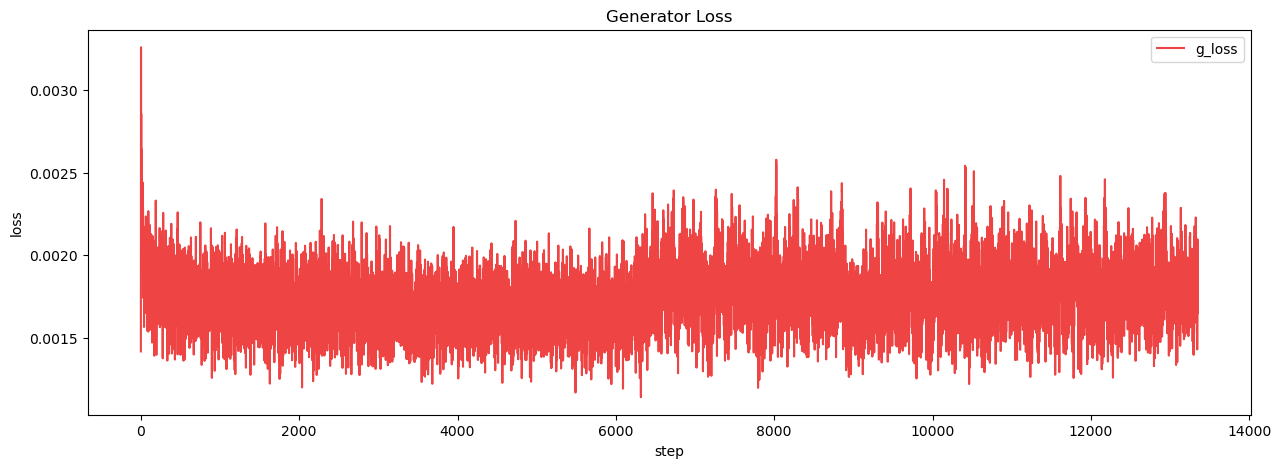

Min generator loss: 0.0011394873727113008


In [14]:
X = np.arange(len(loss_history["d_loss"]))

fig = plt.gcf()
plt.plot(X, loss_history["g_loss"], color=U.get_color(0), label="g_loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.title("Generator Loss")
fig.set_size_inches(15, 5)
plt.show()
print(f"Min generator loss: {min(loss_history['g_loss'])}")

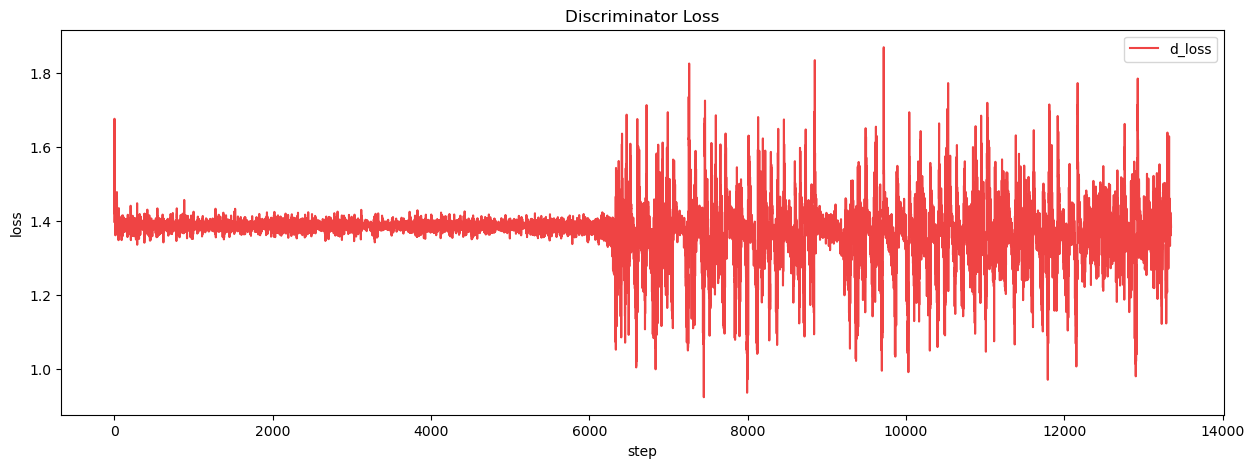

Min discriminator loss: 0.9247055649757385


In [15]:
fig = plt.gcf()
plt.plot(X, loss_history["d_loss"], color=U.get_color(0), label="d_loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.title("Discriminator Loss")
fig.set_size_inches(15, 5)
plt.show()
print(f"Min discriminator loss: {min(loss_history['d_loss'])}")

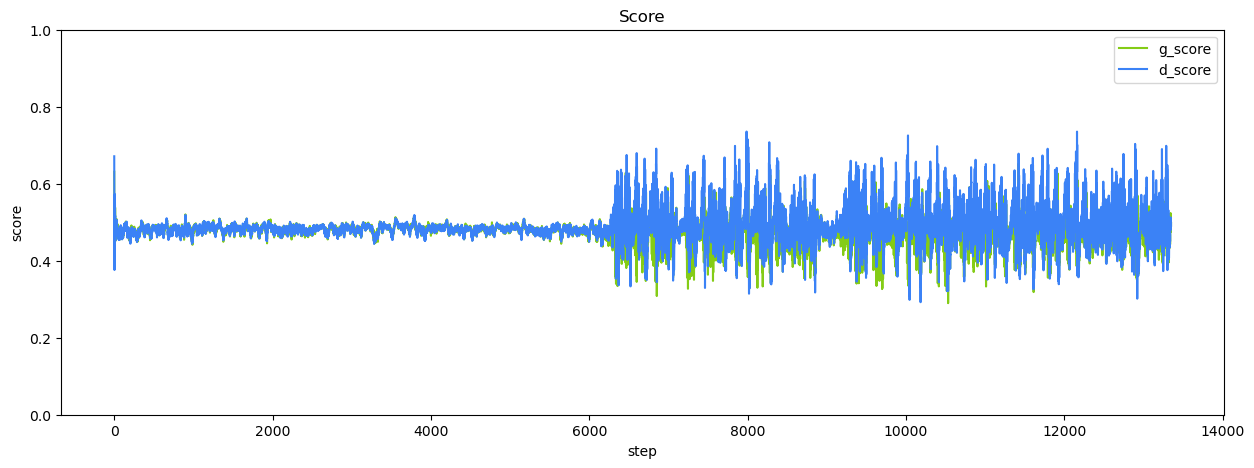

In [16]:
fig = plt.gcf()
plt.plot(X, loss_history["g_score"], color=U.get_color(4), label="g_score")
plt.plot(X, loss_history["d_score"], color=U.get_color(10), label="d_score")
plt.xlabel("step")
plt.ylabel("score")
plt.ylim(0.0, 1.0)
plt.legend()
plt.title("Score")
fig.set_size_inches(15, 5)
plt.show()

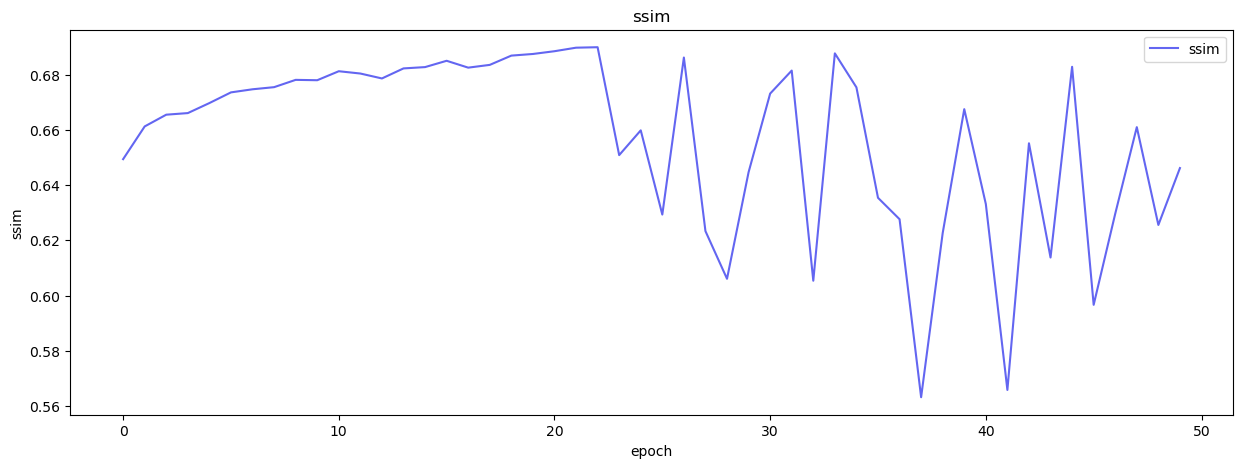

In [17]:
X = np.arange(len(loss_history["ssim"]))

fig = plt.gcf()
plt.plot(X, loss_history["ssim"], color=U.get_color(11), label="ssim")
plt.xlabel("epoch")
plt.ylabel("ssim")
plt.legend()
plt.title("ssim")
fig.set_size_inches(15, 5)
plt.show()

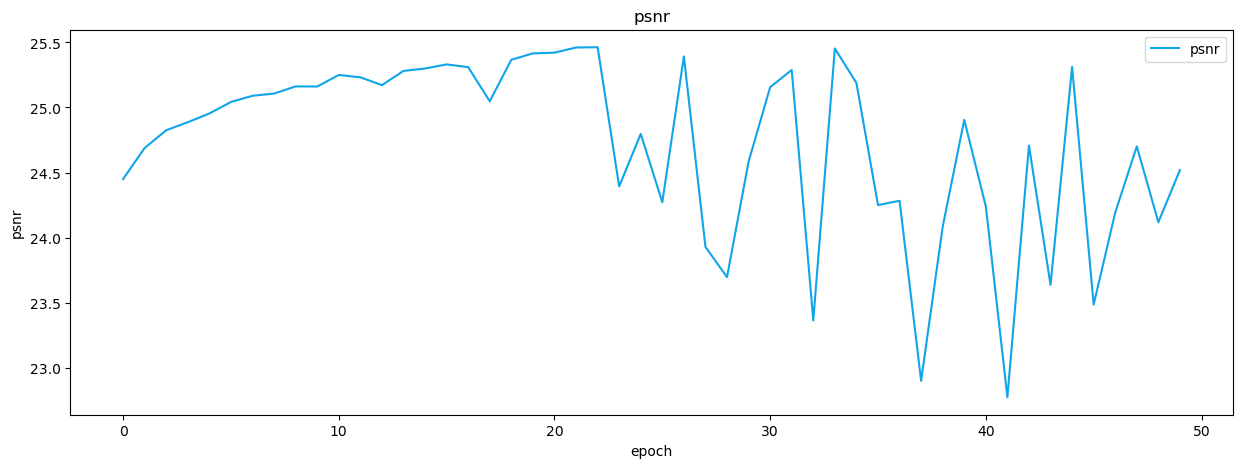

In [18]:
X = np.arange(len(loss_history["psnr"]))

fig = plt.gcf()
plt.plot(X, loss_history["psnr"], color=U.get_color(9), label="psnr")
plt.xlabel("epoch")
plt.ylabel("psnr")
plt.legend()
plt.title("psnr")
fig.set_size_inches(15, 5)
plt.show()

====================Image 1====================
Low Resolution


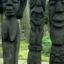

High Resolution


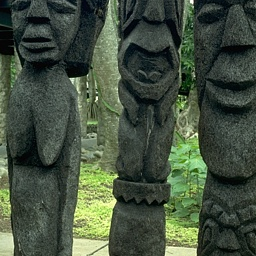

Generated Image


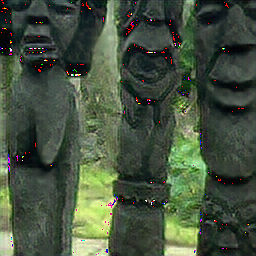

====================Image 2====================
Low Resolution


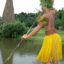

High Resolution


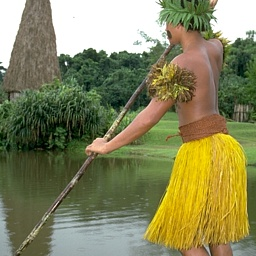

Generated Image


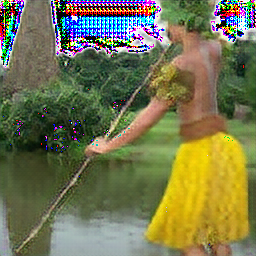

====================Image 3====================
Low Resolution


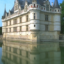

High Resolution


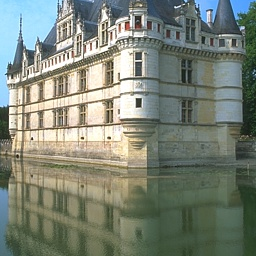

Generated Image


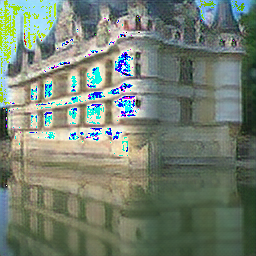

====================Image 4====================
Low Resolution


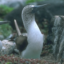

High Resolution


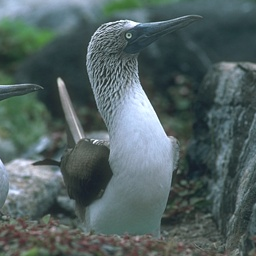

Generated Image


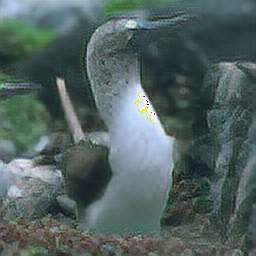

In [19]:
data_iter = iter(test_loader)
z, targets = next(data_iter)

for i in range(min(4, len(z))):
    print(f"====================Image {i+1}====================")
    input_image = TF.to_pil_image(z[i])
    target_image = TF.to_pil_image(targets[i])
    print("Low Resolution")
    display(input_image)
    print("High Resolution")
    display(target_image)

    generated = generator(z[i].unsqueeze(0).to(device))
    generated_image = TF.to_pil_image(generated.cpu().squeeze(0))
    print("Generated Image")
    display(generated_image)

In [20]:
%load_ext tensorboard